In [44]:
import pandas as pd
from tqdm import tqdm  # solo para ver progreso visual

df = pd.read_csv('df_200_con_huecos.csv', index_col=0)

In [45]:
faltantes_restantes = df.groupby('rio_id')['altura_value'].apply(lambda s: s.isna().sum())
print(faltantes_restantes.sum())

12438


# Al principio, 12438 faltantes

In [46]:
# Asegurar que la columna 'date' sea de tipo datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Ordenar y establecer 'date' como índice temporal
df = df.sort_values(['rio_id', 'date']).set_index('date')

# Función para imputar huecos cortos por cada río
def imputar_huecos_cortos(df):
    def imputar_grupo(grupo):
        grupo['altura_value'] = grupo['altura_value'].interpolate(
            method='time',  # interpola usando la escala temporal
            limit=14,       # máximo 14 días consecutivos
            limit_direction='both'
        )
        return grupo
    return df.groupby('rio_id', group_keys=False).apply(imputar_grupo)

# Aplicar al dataset
df = imputar_huecos_cortos(df)

# Restaurar 'date' como columna si querés mantener la estructura original
df = df.reset_index()


C:\Users\COMPU\AppData\Local\Temp\ipykernel_680\4039250173.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('rio_id', group_keys=False).apply(imputar_grupo)


In [47]:
faltantes_restantes = df.groupby('rio_id')['altura_value'].apply(lambda s: s.isna().sum())
print(faltantes_restantes.sum())

5864


# Habiendole sacado todos los huecos de 2 semanas consecutivas: 5864 faltantes:  -60% que antes

In [48]:
# --- Diagnóstico de los faltantes restantes ---

# Contar cuántos faltantes quedan por río
faltantes_restantes = df.groupby('rio_id')['altura_value'].apply(lambda s: s.isna().sum())

# Mostrar solo los ríos que todavía tienen faltantes
faltantes_restantes = faltantes_restantes[faltantes_restantes > 0].sort_values(ascending=False)

print(f"Cantidad de ríos con faltantes: {len(faltantes_restantes)}")
print("\nTop 10 ríos con más faltantes:")
print(faltantes_restantes.head(10))

# Calcular qué porcentaje del total representan
porcentaje_faltantes = (faltantes_restantes.sum() / len(df)) * 100
print(f"\nPorcentaje de valores faltantes en el dataset: {porcentaje_faltantes:.2f}%")


Cantidad de ríos con faltantes: 101

Top 10 ríos con más faltantes:
rio_id
33256-6389    157
32929-6365    146
32300-6465    145
31956-6401    145
31939-6400    145
32837-6508    145
32675-6263    145
33681-6432    145
33257-6395    145
32998-6511    145
Name: altura_value, dtype: int64

Porcentaje de valores faltantes en el dataset: 3.07%


In [49]:
import pandas as pd

# --- Paso 1: Asegurar que los NaN estén bien identificados
df['altura_value'] = pd.to_numeric(df['altura_value'], errors='coerce')

# --- Paso 2: Calcular longitud máxima de huecos consecutivos por río
def max_hueco_consecutivo(serie):
    # Convierte True/False en bloques de consecutivos
    is_na = serie.isna().astype(int)
    # Cortes donde cambia el valor
    grupos = (is_na.diff(1) != 0).cumsum()
    # Filtramos solo grupos donde hay NaN y contamos su tamaño
    longitudes = is_na.groupby(grupos).sum()
    # Retorna el hueco más largo
    return longitudes.max()

max_huecos = (
    df.groupby("rio_id")["altura_value"]
    .apply(max_hueco_consecutivo)
    .sort_values(ascending=False)
)

# --- Paso 3: Mostrar top 10 ríos con huecos más largos
print("🔎 Top 10 ríos con los huecos consecutivos más largos en altura_value:")
print(max_huecos.head(10))

# --- Paso 4 (opcional): Diagnóstico general
print("\nResumen estadístico de longitudes de huecos:")
print(max_huecos.describe())


🔎 Top 10 ríos con los huecos consecutivos más largos en altura_value:
rio_id
33256-6389    134
32929-6365    123
31939-6400    122
32302-6442    122
32300-6465    122
32633-6454    122
32675-6263    122
32837-6508    122
33681-6432    122
33091-6394    122
Name: altura_value, dtype: int64

Resumen estadístico de longitudes de huecos:
count    189.000000
mean      26.439153
std       39.193909
min        0.000000
25%        0.000000
50%        8.000000
75%       23.000000
max      134.000000
Name: altura_value, dtype: float64


In [55]:
import pandas as pd

# Aseguramos el orden correcto
df = df.sort_values(by=["rio_id", "date"])

# --- Función para calcular el hueco más largo de NaNs consecutivos ---
def longest_nan_gap(series):
    return series.isna().astype(int).groupby(series.notna().cumsum()).sum().max()

# --- Calcular el hueco máximo de NaNs para cada río ---
max_huecos = df.groupby("rio_id")["altura_value"].apply(longest_nan_gap)

# --- Identificar ríos con más de 60 días consecutivos de faltantes ---
umbral = 60
rios_problematicos = max_huecos[max_huecos > umbral].index

print(f"Cantidad de ríos eliminados: {len(rios_problematicos)}")
print("Ejemplo de IDs eliminados:", rios_problematicos[:10].tolist())

# --- Eliminar los ríos problemáticos directamente en 'df' ---
df = df[~df["rio_id"].isin(rios_problematicos)]

print(f"Ríos restantes: {df['rio_id'].nunique()}")


Cantidad de ríos eliminados: 31
Ejemplo de IDs eliminados: ['31939-6400', '31956-6401', '32250-6418', '32300-6465', '32301-6444', '32302-6442', '32633-6454', '32675-6263', '32777-6464', '32837-6508']
Ríos restantes: 158


In [56]:
faltantes_restantes = df.groupby('rio_id')['altura_value'].apply(lambda s: s.isna().sum())
print(faltantes_restantes.sum())

1894


# Eliminando aquellos rios que tienen hueco de +60 dias consecutivos 💀.
## Resultados: de 5864 a 1894   === -66%
### Ríos restantes: 158


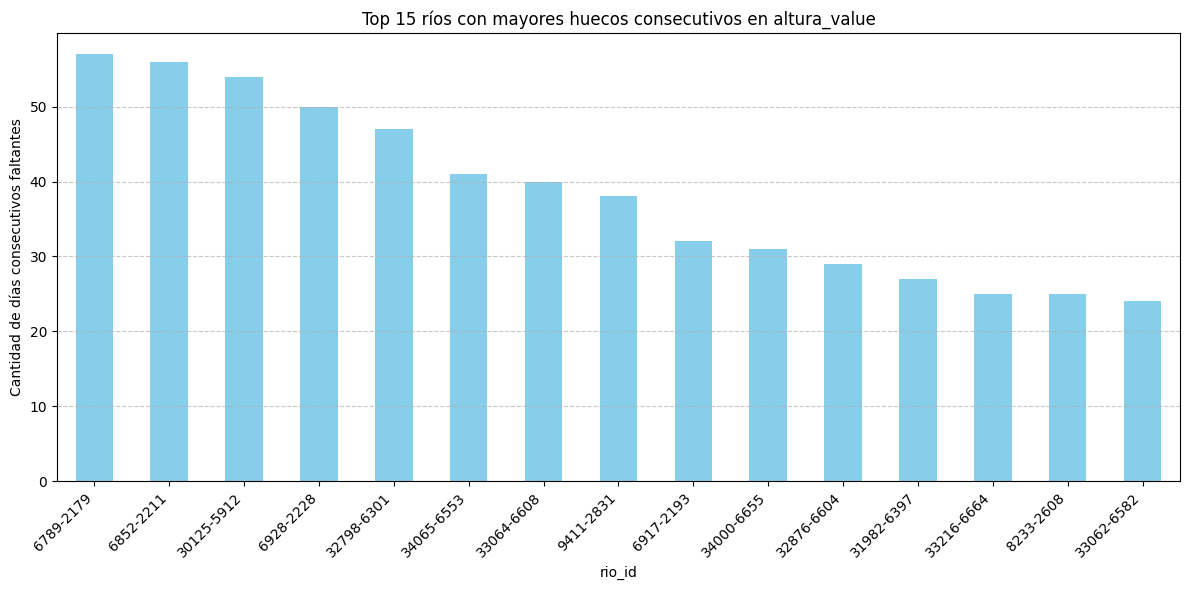

rio_id
6789-2179     57
6852-2211     56
30125-5912    54
6928-2228     50
32798-6301    47
34065-6553    41
33064-6608    40
9411-2831     38
6917-2193     32
34000-6655    31
32876-6604    29
31982-6397    27
33216-6664    25
8233-2608     25
33062-6582    24
Name: altura_value, dtype: int64


In [58]:
import matplotlib.pyplot as plt

# --- Calcular la longitud máxima de huecos consecutivos por río ---
def longest_nan_gap(series):
    return series.isna().astype(int).groupby(series.notna().cumsum()).sum().max()

# Calcular hueco máximo por rio_id
huecos_maximos = df.groupby("rio_id")["altura_value"].apply(longest_nan_gap)

# Ordenar de mayor a menor
huecos_ordenados = huecos_maximos.sort_values(ascending=False)

# Mostrar los 15 con más huecos consecutivos
top_ranking = huecos_ordenados.head(15)

# --- Graficar ---
plt.figure(figsize=(12, 6))
top_ranking.plot(kind="bar", color="skyblue")
plt.title("Top 15 ríos con mayores huecos consecutivos en altura_value")
plt.ylabel("Cantidad de días consecutivos faltantes")
plt.xlabel("rio_id")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- (Opcional) Mostrar los valores exactos ---
print(top_ranking)


In [59]:
# Lista de rios a eliminar
rios_a_eliminar = [
    "6789-2179",
    "6852-2211",
    "30125-5912",
    "6928-2228",
    "32798-6301",
    "34065-6553",
    "33064-6608",
    "9411-2831",
    "6917-2193",
    "34000-6655",
    "32876-6604",
    "31982-6397"
]

# Eliminar directamente del df original
df = df[~df["rio_id"].isin(rios_a_eliminar)]

# Verificar resultado
print(f"Se eliminaron {len(rios_a_eliminar)} ríos. Total de registros actuales: {len(df)}")
print(f"Ríos únicos restantes: {df['rio_id'].nunique()}")


Se eliminaron 12 ríos. Total de registros actuales: 147314
Ríos únicos restantes: 146


In [61]:
faltantes_restantes = df.groupby('rio_id')['altura_value'].apply(lambda s: s.isna().sum())
print(faltantes_restantes.sum())

1226


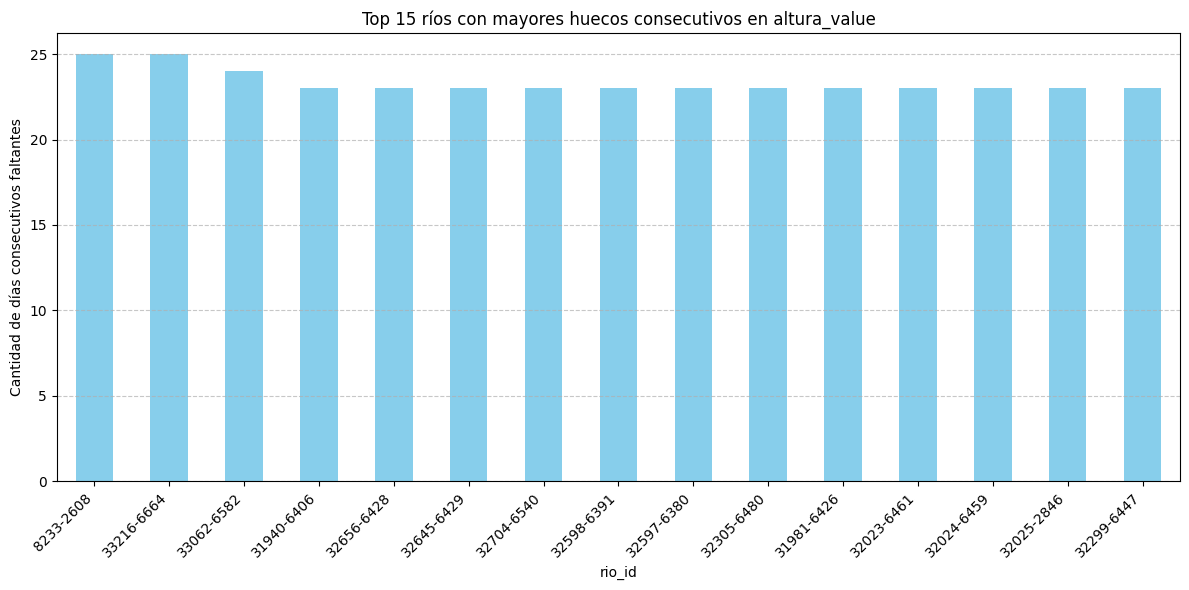

rio_id
8233-2608     25
33216-6664    25
33062-6582    24
31940-6406    23
32656-6428    23
32645-6429    23
32704-6540    23
32598-6391    23
32597-6380    23
32305-6480    23
31981-6426    23
32023-6461    23
32024-6459    23
32025-2846    23
32299-6447    23
Name: altura_value, dtype: int64


In [62]:
import matplotlib.pyplot as plt

# --- Calcular la longitud máxima de huecos consecutivos por río ---
def longest_nan_gap(series):
    return series.isna().astype(int).groupby(series.notna().cumsum()).sum().max()

# Calcular hueco máximo por rio_id
huecos_maximos = df.groupby("rio_id")["altura_value"].apply(longest_nan_gap)

# Ordenar de mayor a menor
huecos_ordenados = huecos_maximos.sort_values(ascending=False)

# Mostrar los 15 con más huecos consecutivos
top_ranking = huecos_ordenados.head(15)

# --- Graficar ---
plt.figure(figsize=(12, 6))
top_ranking.plot(kind="bar", color="skyblue")
plt.title("Top 15 ríos con mayores huecos consecutivos en altura_value")
plt.ylabel("Cantidad de días consecutivos faltantes")
plt.xlabel("rio_id")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- (Opcional) Mostrar los valores exactos ---
print(top_ranking)


## Chau 12 rios que tienen huecos consecutivos de 1 mes.
## Restultados: Ríos únicos restantes: 146
## Registros faltantes: 1226 vs 1894

In [66]:
# Paso 1: asegurarnos que la fecha esté en formato datetime
df["date"] = pd.to_datetime(df["date"])

# Paso 2: ordenar por rio_id y fecha
df = df.sort_values(["rio_id", "date"])

# Paso 3: aplicar spline cúbico por grupo
df["altura_value"] = (
    df.groupby("rio_id")["altura_value"]
    .transform(lambda s: s.interpolate(method='spline', order=3, limit=23, limit_direction='both'))
)

# Paso 4: verificación de faltantes
faltantes_final = df["altura_value"].isna().sum()
print(f"Faltantes restantes después de imputar con spline cúbico: {faltantes_final}")

# (Opcional) Paso 5: suavizado leve (por río) para evitar oscilaciones
df["altura_value"] = (
    df.groupby("rio_id")["altura_value"]
    .transform(lambda s: s.rolling(window=5, min_periods=1, center=True).mean())
)


Faltantes restantes después de imputar con spline cúbico: 3


In [69]:
df["altura_value"] = df.groupby("rio_id")["altura_value"].transform(lambda s: s.fillna(method='ffill').fillna(method='bfill'))


C:\Users\COMPU\AppData\Local\Temp\ipykernel_680\567842749.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["altura_value"] = df.groupby("rio_id")["altura_value"].transform(lambda s: s.fillna(method='ffill').fillna(method='bfill'))


In [70]:
faltantes_final = df["altura_value"].isna().sum()
print(f"Faltantes restantes después de imputar con spline cúbico: {faltantes_final}")

Faltantes restantes después de imputar con spline cúbico: 0


In [71]:
df.to_csv('df_datos_imputados_final.csv')